In [1]:
!unzip -P memetaskaaai22 "/content/drive/MyDrive/Memotion/Memotion 2.0 Data/Memotion2.zip"

Archive:  /content/drive/MyDrive/Memotion/Memotion 2.0 Data/Memotion2.zip
  inflating: memotion_train.csv      
  inflating: memotion_val.csv        


In [2]:
!unzip -P memeimageaaai22 "/content/drive/MyDrive/Memotion/Memotion 2.0 Data/image folder.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train_images/415.jpg    
  inflating: train_images/4150.jpg   
  inflating: train_images/4151.jpg   
  inflating: train_images/4152.jpg   
  inflating: train_images/4153.jpg   
  inflating: train_images/4154.jpg   
  inflating: train_images/4155.jpg   
  inflating: train_images/4156.jpg   
  inflating: train_images/4157.jpg   
  inflating: train_images/4158.jpg   
  inflating: train_images/4159.jpg   
  inflating: train_images/416.jpg    
  inflating: train_images/4160.jpg   
  inflating: train_images/4161.jpg   
  inflating: train_images/4162.jpg   
  inflating: train_images/4163.jpg   
  inflating: train_images/4164.jpg   
 extracting: train_images/4165.jpg   
  inflating: train_images/4166.jpg   
  inflating: train_images/4167.jpg   
  inflating: train_images/4168.jpg   
  inflating: train_images/4169.jpg   
  inflating: train_images/417.jpg    
  inflating: train_images/4170.jpg   
  inflating: train_images/4171.jpg   

In [3]:
import pandas as pd


In [4]:
train = pd.read_csv("/content/memotion_train.csv")

In [5]:
val = pd.read_csv("/content/memotion_val.csv")

In [6]:
train = train.drop(columns = ['Image url','humour','sarcastic','offensive','motivational','classification_based_on'])

In [7]:
train.head()

,Id,ocr_text,overall_sentiment
0,1,enters into a wrong class teacher and students,neutral
1,2,dj if you single make some nooooissssseeee my ...,neutral
2,3,everyone sit like a lady me,neutral
3,4,when youre about to watch a 2 hour educational...,neutral
4,5,government work from home olympic swimmers nsdf,neutral


In [8]:
train.columns = ['file_name','Text Transcription','label']

In [9]:
# train['classification_based_on'].unique()

In [10]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 4.7 MB/s 
     |████████████████████████████████| 895 kB 30.7 MB/s 
     |████████████████████████████████| 596 kB 21.3 MB/s 
     |████████████████████████████████| 67 kB 213 kB/s 
     |████████████████████████████████| 6.8 MB 33.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [11]:
import pandas as pd

In [12]:
df = train

In [13]:
from transformers import (
   AutoConfig,
   AutoTokenizer,
   TFAutoModelForSequenceClassification,
   AdamW,
   glue_convert_examples_to_features
)
import tensorflow as tf
import tensorflow_datasets as tfds
import json

In [14]:

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
# RANDOM_SEED = 42
# np.random.seed(RANDOM_SEED)
# torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7276054211884072998
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15371862016
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4325666499600722314
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [16]:
from torchvision import datasets, transforms


In [17]:
from PIL import Image
import requests
from transformers import VisionTextDualEncoderModel, VisionTextDualEncoderProcessor, ViTFeatureExtractor, BertTokenizer

In [18]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
processor = VisionTextDualEncoderProcessor(feature_extractor, tokenizer)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [19]:
_transforms = transforms.Compose(
    [
        transforms.Resize((448, 448)),
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        # transforms.ToTensor()
    ]
    
)

In [20]:

class GPReviewDataset(Dataset):
  def __init__(self, Text,image, Label, processor):
    self.Text = Text
    self.image = image
    self.Label = Label
    # self.tokenizer = tokenizer
    # self.feature_extractor = feature_extractor
    self.processor = processor
    # self.max_len = max_len
  def __len__(self):
    return len(self.Text)
  def __getitem__(self, item):
    img_path = self.image[item]
    img = Image.open("/content/train_images/"+img_path).convert('RGB')
    img_transformed = _transforms(img)
    Text = str(self.Text[item])
    Label = self.Label[item]
    inputs = processor(text=Text, images=img_transformed, return_tensors="pt", padding='max_length')
    # inputs = inputs.squeeze(0)
    # print(Text)
    # print(img_transformed.shape)
    # print(Label.shape)
    # print(inputs.input_ids.shape)
    # print(Text)
    # print(Text)
    # print(inputs.pixel_values.shape)
    return {
      'input_ids': inputs.input_ids.squeeze(0),
      'attention_mask': inputs.attention_mask.squeeze(0),
      'pixel_values' : inputs.pixel_values.squeeze(0),
      'Label': torch.tensor(Label, dtype=torch.long)
    }



In [21]:
df

,file_name,Text Transcription,label
0,1,enters into a wrong class teacher and students,neutral
1,2,dj if you single make some nooooissssseeee my ...,neutral
2,3,everyone sit like a lady me,neutral
3,4,when youre about to watch a 2 hour educational...,neutral
4,5,government work from home olympic swimmers nsdf,neutral
...,...,...,...
6995,6996,my plan my budget,positive
6996,6997,emoji scissors wouldnt close in real life inte...,neutral
6997,6998,me ready to get a good nights sleep my left no...,positive
6998,6999,you get new brain wrinkles when you learn some...,neutral


In [22]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [23]:
df['label'] = le.fit_transform(df['label'])

In [24]:
df['file_name'] = df['file_name'].apply(lambda x: str(x))

In [25]:
df['file_name'] = df['file_name'] + ".jpg"

In [26]:
df_train, df_val = train_test_split(
  df,
  test_size=0.20,
  stratify = df.label.values,
  random_state=42
)
df_val, df_test = train_test_split(
  df_val,
  test_size=0.50,
  stratify = df_val.label.values,
  random_state=42
)


df_train.shape, df_val.shape,df_test.shape

((5600, 3), (700, 3), (700, 3))

In [27]:


def create_data_loader(df, processor, batch_size):
  ds = GPReviewDataset(
    Text=df['Text Transcription'].to_numpy(),
    image = df.file_name.to_numpy(),
    Label=df.label.to_numpy(),
    processor=processor
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0
  )

In [28]:
BATCH_SIZE = 8
train_data_loader = create_data_loader(df_train, processor, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, processor, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, processor, BATCH_SIZE)

In [29]:

class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = VisionTextDualEncoderModel.from_vision_text_pretrained("google/vit-base-patch16-224", "bert-base-uncased")
    
    self.drop = nn.Dropout(p=0.30)
    self.out = nn.Linear(1024, n_classes)
  def forward(self, input_ids, attention_mask,pixel_values):
    outputs = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      pixel_values=pixel_values,
      return_dict=True)
    output = self.drop(torch.cat((outputs.text_embeds,outputs.image_embeds),1))
    return self.out(output)

In [30]:
class_names = ['0','1','2']

In [31]:
modell = SentimentClassifier(len(class_names))
modell = modell.to(device)

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
The projection layer and logit scale weights `['visual_projection.weight', 'text_projection.weight', 'logit_scale']` are newly initialized. You should prob

In [32]:
EPOCHS = 3
optimizer = AdamW(modell.parameters(), lr=2e-5, correct_bias=True)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [33]:
loss_fn = nn.CrossEntropyLoss().to(device)

In [34]:

def train_epoch(
  modell,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples):
  modell = modell.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    pixel_values = d['pixel_values'].to(device)
    Label = d["Label"].to(device)
    outputs = modell(
      input_ids=input_ids,
      attention_mask=attention_mask,
      pixel_values = pixel_values
    )
    
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, Label)
    correct_predictions += torch.sum(preds == Label)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(modell.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [35]:
def eval_model(modell, data_loader, loss_fn, device, n_examples):
  modell = modell.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      pixel_values = d['pixel_values'].to(device)
      Label = d["Label"].to(device)
      outputs = modell(
        input_ids=input_ids,
        attention_mask=attention_mask,
        pixel_values = pixel_values
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, Label)
      correct_predictions += torch.sum(preds == Label)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [36]:

%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    modell,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    modell,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(modell.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------
Train loss 0.9065769302419254 accuracy 0.6435714285714286
Val   loss 0.8921851603822275 accuracy 0.6442857142857142

Epoch 2/3
----------
Train loss 0.8903101505126272 accuracy 0.6442857142857142
Val   loss 0.8906929252499883 accuracy 0.6442857142857142

Epoch 3/3
----------
Train loss 0.8837851961169924 accuracy 0.6442857142857142
Val   loss 0.8911043903367086 accuracy 0.6442857142857142

CPU times: user 26min 34s, sys: 1min 4s, total: 27min 39s
Wall time: 27min 46s


In [37]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  id = []
  ip = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      # texts = d["Text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      pixel_values = d['pixel_values'].to(device)
      targets = d["Label"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        pixel_values = pixel_values
      )
      _, preds = torch.max(outputs, dim=1)
      # ids = d['ID']
      # ips = d['img_path']
      # probs = F.softmax(outputs, dim=1)
      
      # review_texts.extend(texts)
      predictions.extend(preds)
      # id.extend(ids)
      # ip.extend(ips)
      # prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  # idss = id
  # ipss = ip
  # prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return real_values,predictions

In [38]:
real_values,y_pred = get_predictions(
  modell,
  test_data_loader
)

In [39]:
print(classification_report(real_values, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.64      1.00      0.78       451
           2       0.00      0.00      0.00       151

    accuracy                           0.64       700
   macro avg       0.21      0.33      0.26       700
weighted avg       0.42      0.64      0.50       700



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.64      1.00      0.78       451
           2       0.00      0.00      0.00       151

    accuracy                           0.64       700
   macro avg       0.21      0.33      0.26       700
weighted avg       0.42      0.64      0.50       700



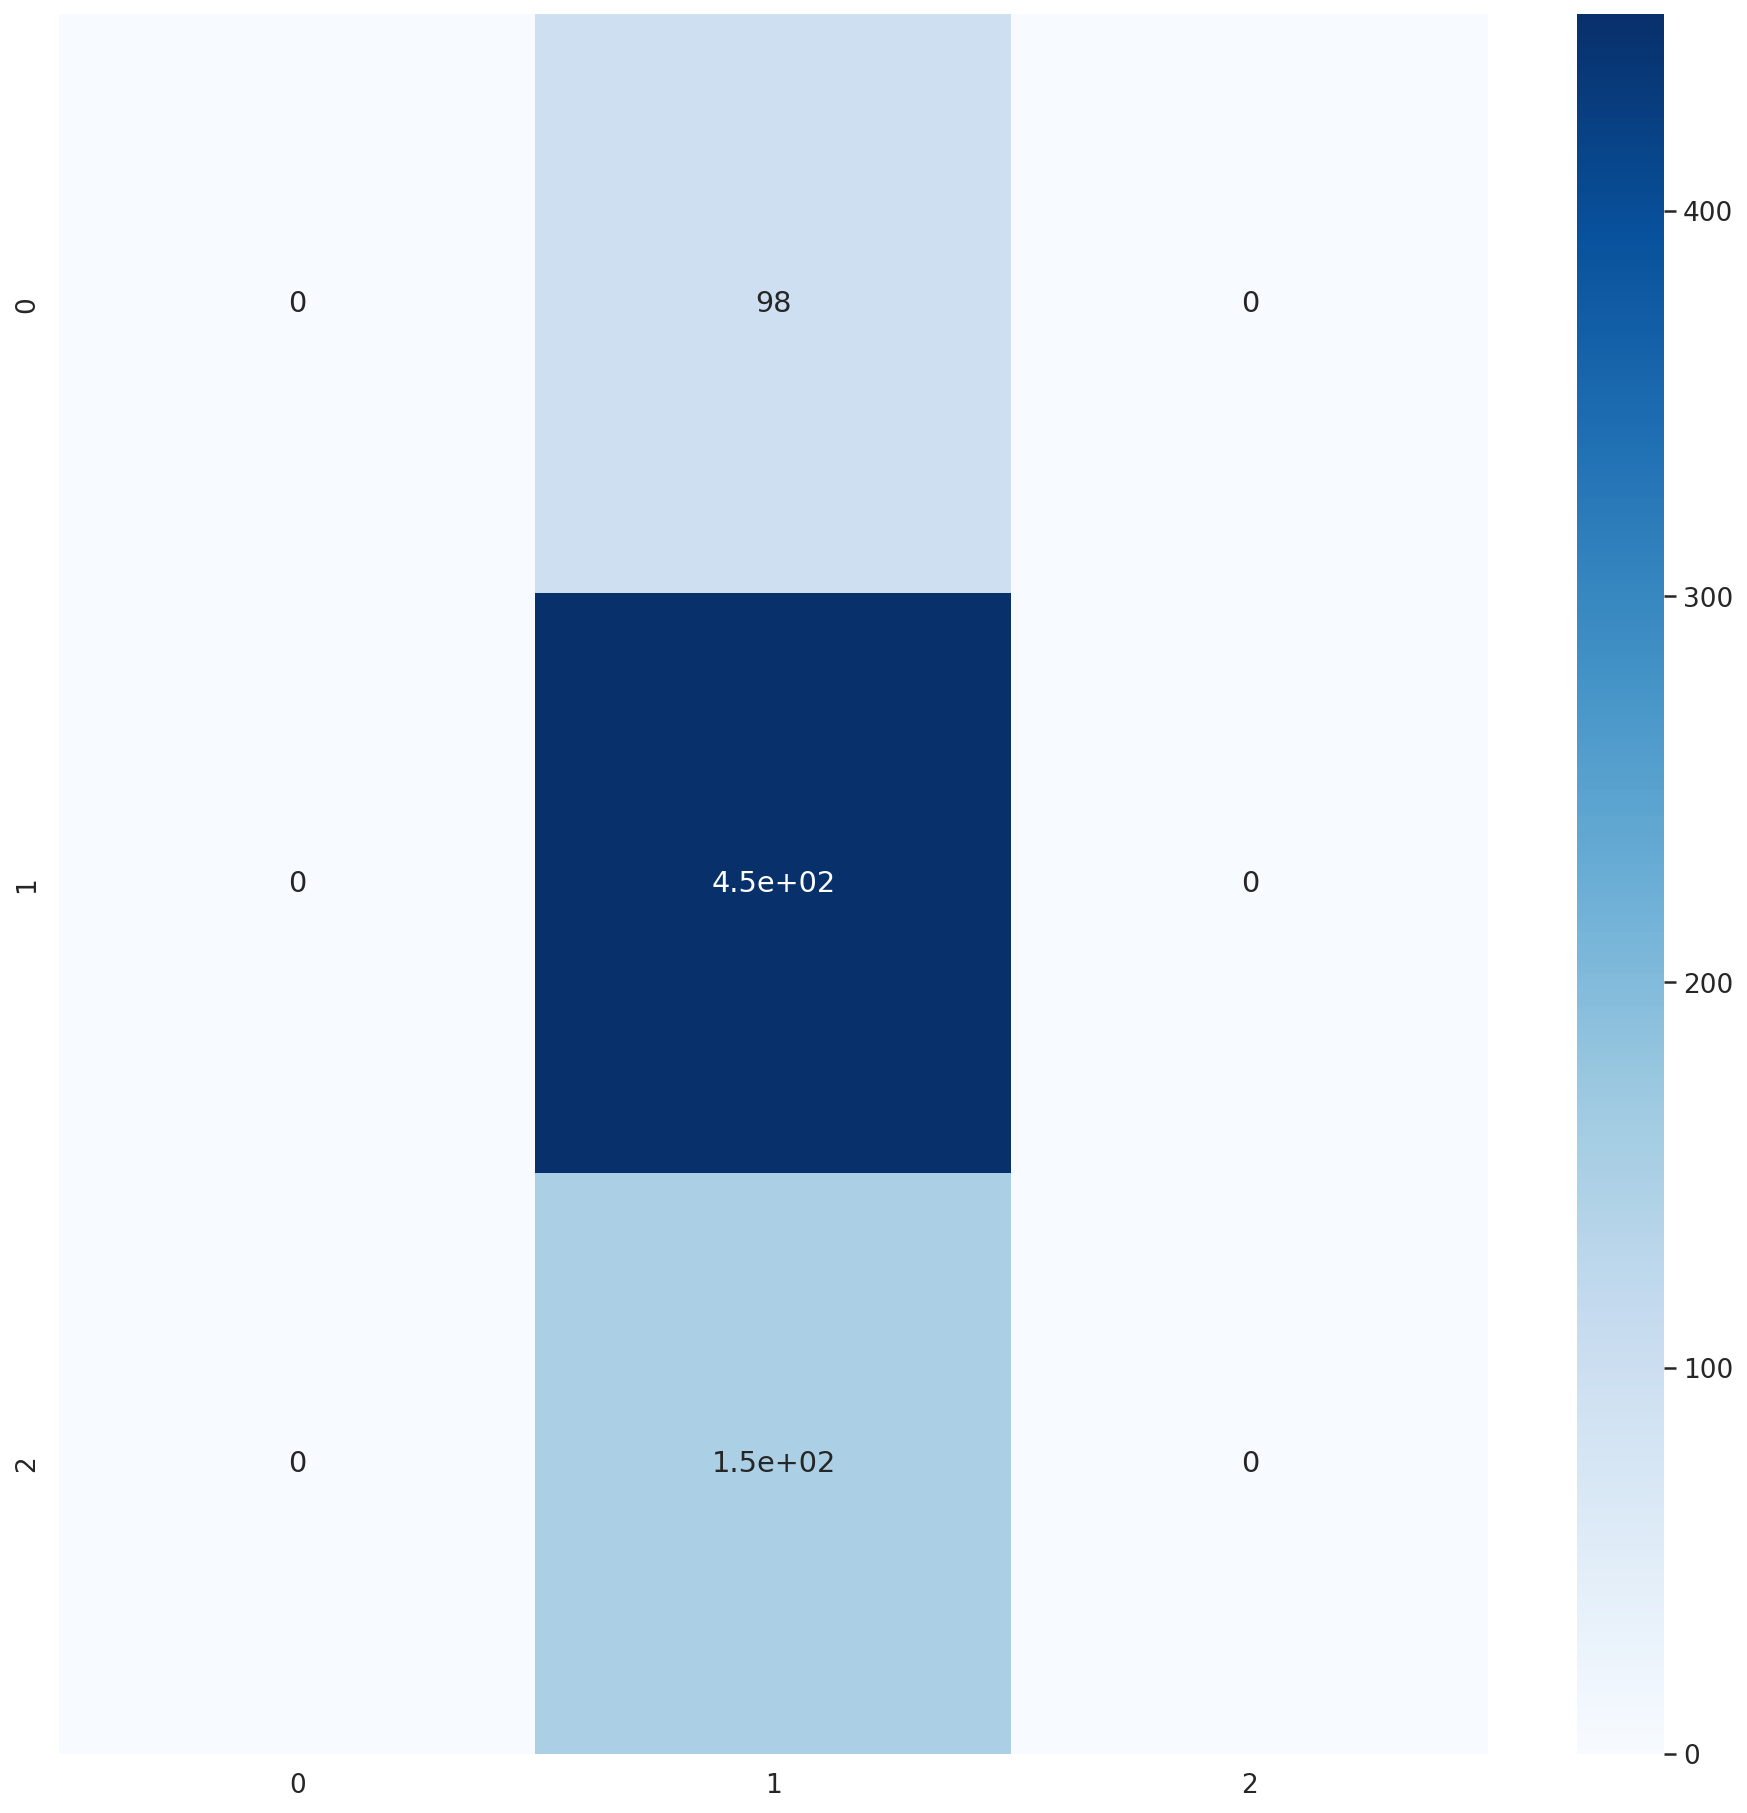

In [40]:
confusionmatrix = confusion_matrix(real_values, y_pred)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(real_values, y_pred))